In [2]:
import getpass
if getpass.getuser() == 'mshaaban':
    from bit_tools.plot import hide_cell
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai')
    jtplot.style(ticks=True, grid=False, figsize=(8, 4))
def hide(tex):
    if getpass.getuser() == 'mshaaban':
        return hide_cell(ttext=tex)
    else:
        pass
hide("shaaban_imports")

In [3]:
import numpy as np
import sys
import os
from astropy import units as u
from astropy import constants as const
from astropy.cosmology import WMAP9
from matplotlib import pyplot as plt
from pprint import pprint
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
from astropy.io import fits
import ccdproc as ccdp
import pickle
import bit_tools as bt
hide("imports")

# Lensing Equaitons By Example

In this notebook I will work through some lensing math in order to familiarize myself and the reader with some of the basics of weak and strong lensing. The primary source for this demo can be found here: http://www.ita.uni-heidelberg.de/~massimo/sub/Lectures/gl_all.pdf

Other useful sources:
- arxiv: 1612.06535
- arxiv: 1710.03235

The end goal for this demo is to undestand how the lensing data products relate to one another in order to extract mass distribution of an object given a noisy shear map of background sources.

## Important Definetions

Due to the physics of momentum transfer one expects that a photon passing by a point mass will have its path altered due to its gravitational potential. Specifically one finds that the path of light will be deflected by an angle $\hat \alpha$. Treating this problem in general relativity we find that this deflection is exactly a factor 2 greater than that would be expected from newtonian mechanics and is given by:

<center>Angle of light deflection by a point source:</center>

$$ |\vec{\hat \alpha}| = 2 |\vec{ \hat \alpha}|_{newton} = \frac{4GM}{c^2 b}$$

where $G$ is the gravitional constant, $M$ is the point source mass, $c$ is the speed of light and $b$ is the radius of closest aproach. The moral of the story here is that the magnitude of the deflection scales linearly with mass of the point source. This is trivially generalizable to extended sources by simply integrating over a mass distribution. In the absolute majority of lensing cases the distance between the observer, the lens, and the background source is much greater than the size of the lens. Thus for lensing it suffices to describe the matter distribution by its surface density $\Sigma$ simply defined as the projection of the three dimensional density $\rho$ along the line of sight given by:

<center>Lens surface density:</center>

$$\Sigma(\vec{\xi}) =  \int \rho(\vec{\xi},z) \ dz$$

where $\vec{\xi}$ is the 2d vector on lens plane and $\rho$ is the standard 3d mass density. Thus the deflection angle for an arbitrary mass distribution can now be given by: 


<center>Angle of light deflection by a thin lens of arbitrary 2d distribution:</center>

$$\vec{\hat \alpha}(\vec \xi) = \frac{4G}{c^2} \int \frac{(\vec{\xi}-\vec{{\xi'}}) \Sigma(\vec{{\xi'}})}{|\vec{\xi}-\vec{{\xi'}}|^2} d^2 \xi' = -\frac{2}{c^2} \int \vec \nabla \Phi\ d \lambda$$  

where $\Phi$ is the newtonian gravitational potential and $\nabla$ is the gradient of the potential perpandicular to the light rays path.

## Lens Equation

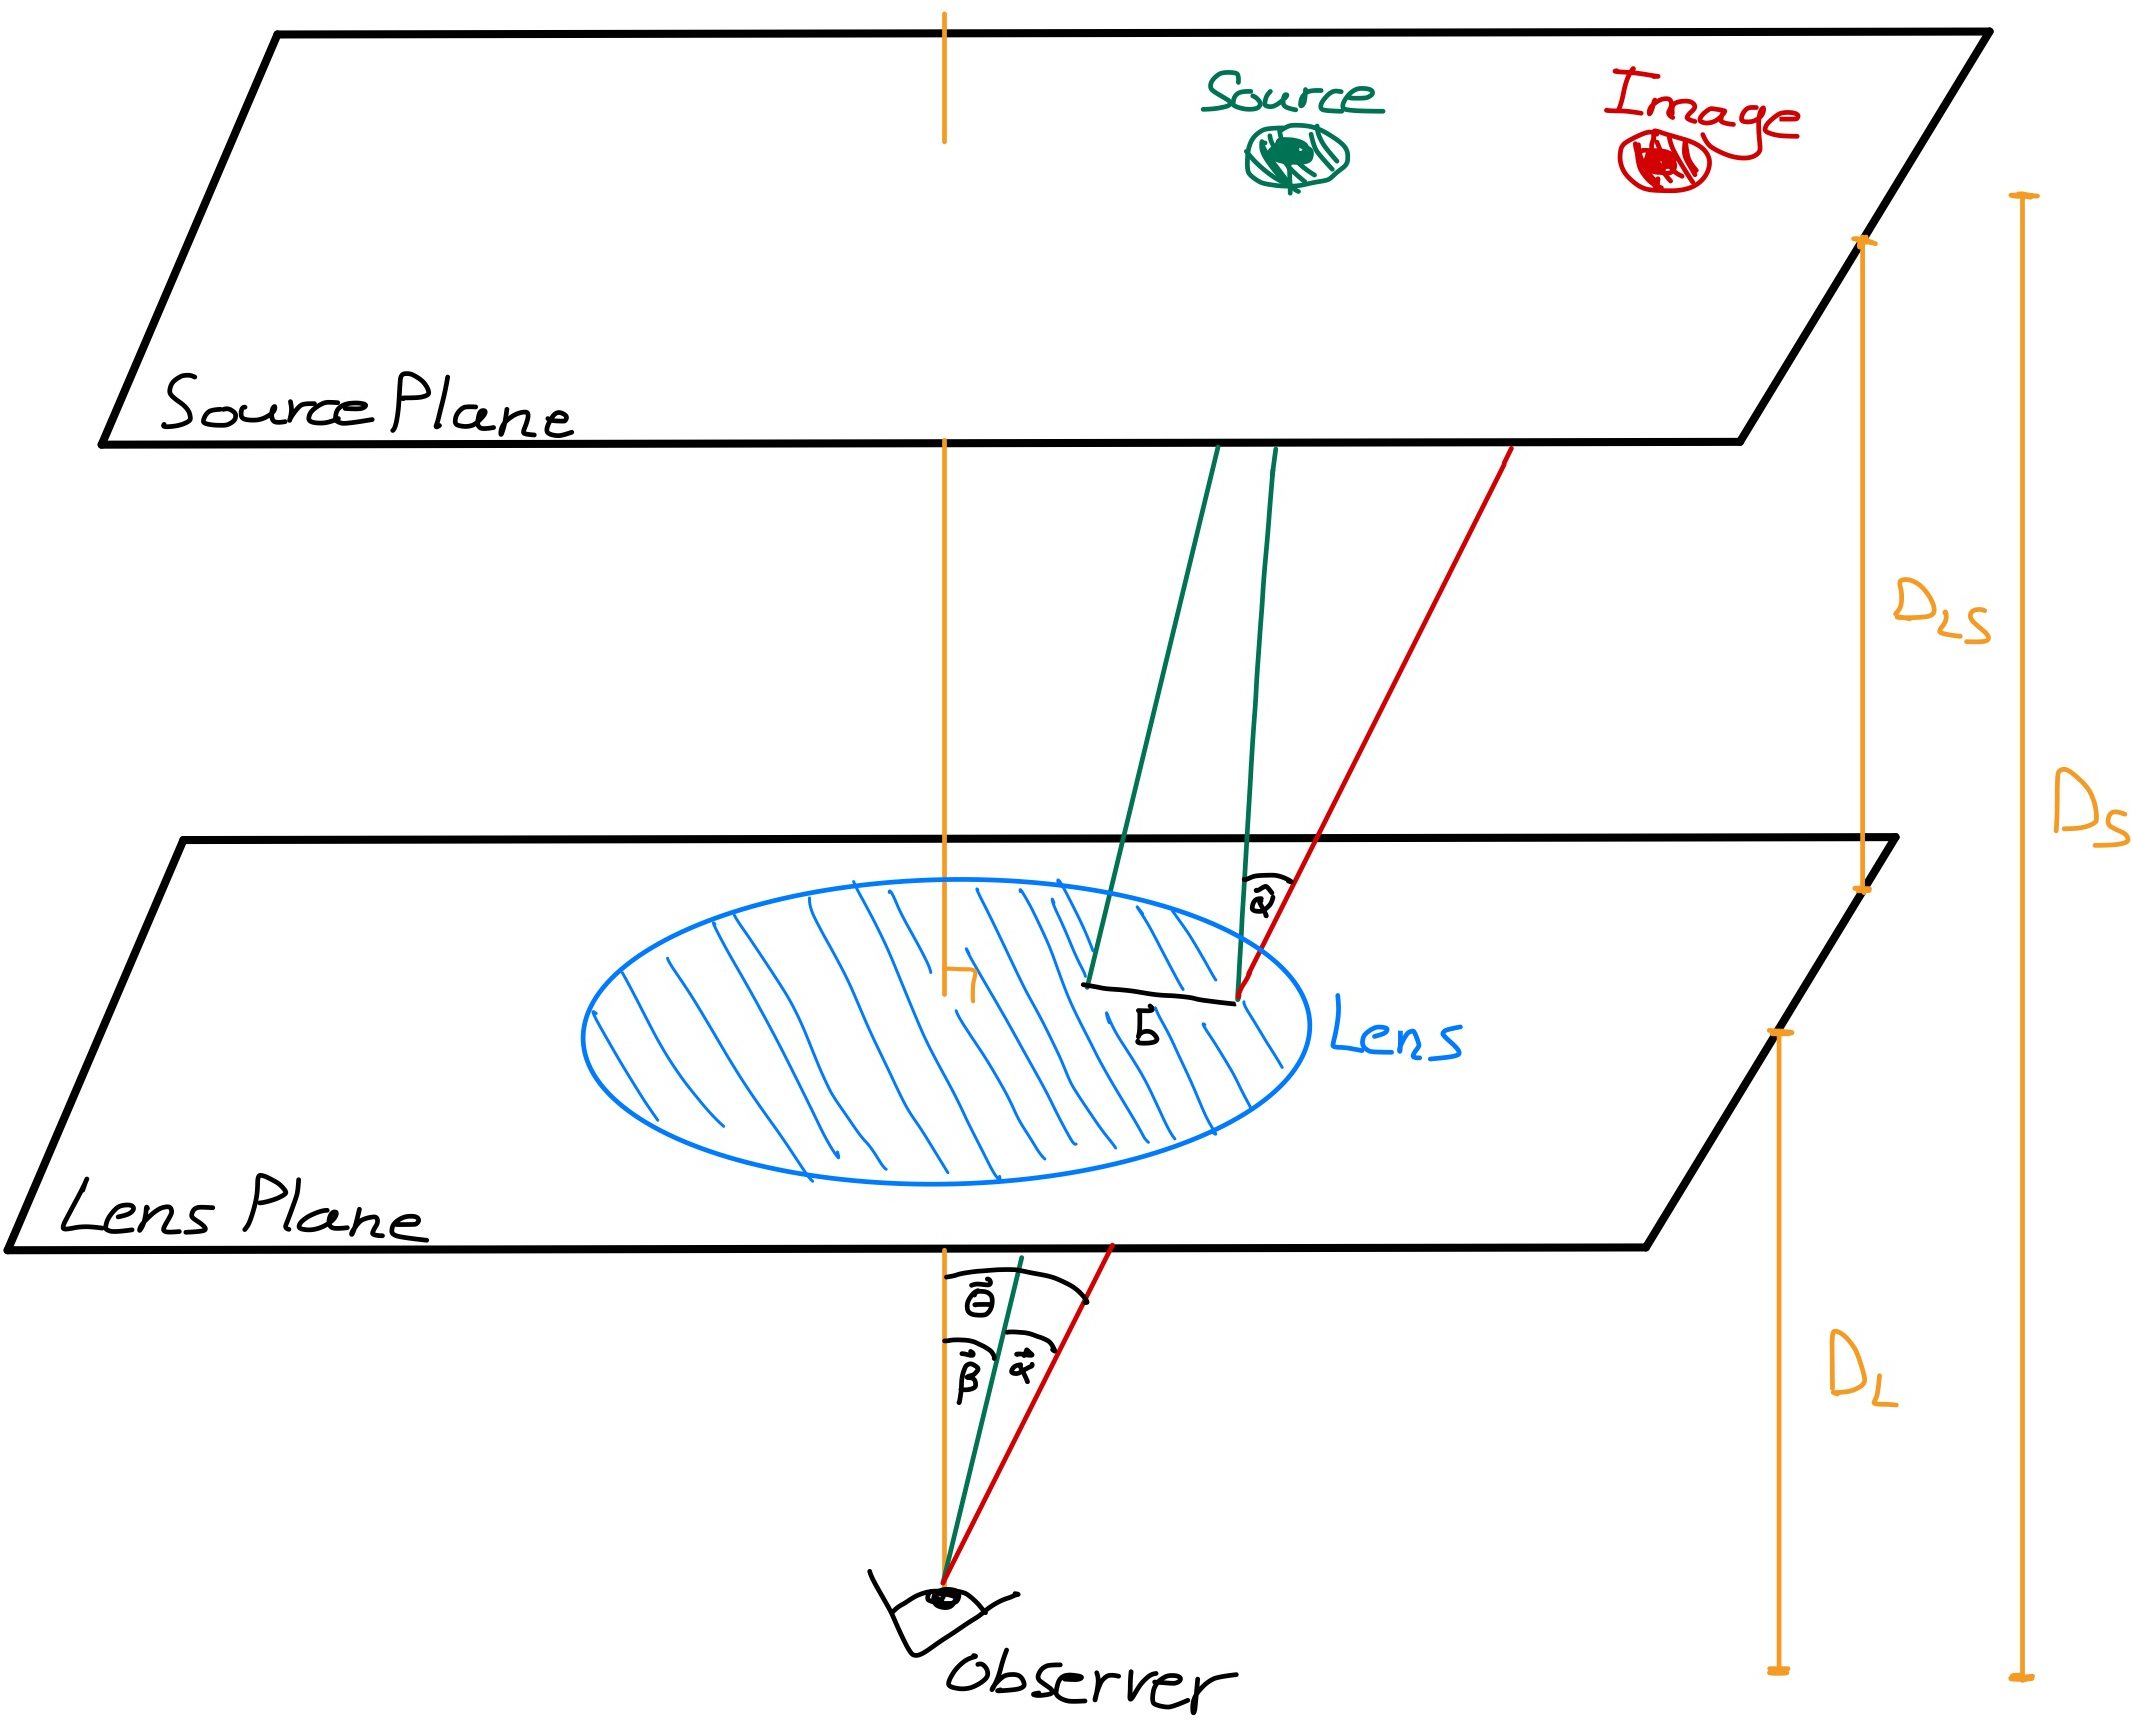

In [4]:
from IPython.display import Image
Image(filename='lens.jpg',width=700) 

The above figure shows a generic lensing system, this diagram will be used to extract the fundemental equations of any lensing system known as the lens equaitons. Note the following definetions:

- $ D_{ij} $ is the angular diameter dsitance from i to j, observer is denoted with no index (e.g. $D_s$ observer to source distance)
- $ \vec \xi$ 2d coordinates on the lens plane
- $ \vec \eta$ 2d coordinates on the source plane
- $\vec \beta$ angular position of the source with respect to the optical axis
- $ \vec \theta $ apparent angular position of the source (observable)
- $\vec{\hat{\alpha}} $ deflection angle
- $\vec \alpha$ reduced deflection angle defined by: $ \vec \alpha(\vec \theta) = \frac{D_{LS}}{D_S} \vec{\hat{\alpha}}(\vec \theta)$

Geometrically speaking it becomes apparent that one can relate these angles and distances to each other as follows, 
For small angles the lens equation is the following simply the statement that $\vec \theta = \vec \beta + \vec \alpha$. Basically all this is saying is that $\alpha$ has $\theta$ dependance and is therfore sensitive not just to the amount of mass but its distribution.

Note that in this set up the following relationship will be assumed

$$\nabla_{\perp} \approx \frac{1}{D_L} \nabla_{\theta}$$

## Lensing Potential

$$ $$

## Worked Example

## Lensing by Galaxy Cluster

$$ \nabla^2 \Psi =  2 \kappa(\vec \theta)  = \frac{2}{\pi} \int D_1( \theta -  \theta')\ \gamma_1 + D_2(\theta -  \theta')\ \gamma_2 \ d^2 \theta'$$

## Andrew Example

In [5]:
from __future__ import division

In [4]:
# Define some useful costants
Lbox = 25.0*u.Mpc
Lrays = 25.0*u.Mpc
Ncells = 2048
Nrays = 4096
subsamp = 1

In [5]:
# xs, ys in Mpc in lens plane, crit_curves in same units
# load npz lens file 
lens_data = np.load("../Shaaban/lens_properties_Group_00003.npz",allow_pickle=True)

# populate the info
einstein_radius = lens_data['eqv_einstein_radius'] # arcsec
zLens = lens_data['zLens']
zSource = lens_data['zSource']
M200 = lens_data['M200'] # Msun

In [20]:
# load npz kapa file
# xs, ys in Mpc in aens plane, kappa measured on that grid
kappa_data = np.load("../Shaaban/kappa_Group_00003.npz")

# populate the info
kappa = kappa_data['kappa']
gamma1 = kappa_data['gamma1']
gamma2 = kappa_data['gamma2']
gamma = np.sqrt(gamma1**2 + gamma2**2)

# physical lens plane coordinates
xs, ys = kappa_data['xs']*u.Mpc, kappa_data['ys']*u.Mpc

# convert to angular coordinates
xs = ((xs/WMAP9.angular_diameter_distance(zLens))*u.rad).to_value('arcmin')
ys = ((ys/WMAP9.angular_diameter_distance(zLens))*u.rad).to_value('arcmin')

# for plotitng
kappa_min = 0.9e-3
kappa_max = 1.1
gamma_min = 0.9e-2
gamma_max = 1.1

In [21]:
galaxy_data = np.load('../Shaaban/galaxy_catalogue_Group_00003.npz')

galaxy_x, galaxy_y = galaxy_data['x']*u.Mpc, galaxy_data['y']*u.Mpc
galaxy_x = ((galaxy_x/WMAP9.angular_diameter_distance(zLens))*u.rad).to_value('arcmin')
galaxy_y = ((galaxy_y/WMAP9.angular_diameter_distance(zLens))*u.rad).to_value('arcmin')

In [22]:
# xrays, yrays, alphax, alphay in dimensionless coordinates
alpha_data = np.load("../Shaaban/alpha_Group_00003.npz")

# mass distributions, gas_sigma, star_sigma, dm_sigma
sigma_data = np.load("../Shaaban/sigma_Group_00003.npz")

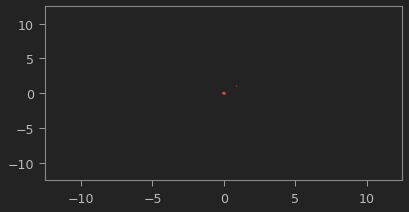

In [11]:
xraysgrid, yraysgrid = np.meshgrid(alpha_data['yrays'],alpha_data['xrays'],indexing='ij')
cc = plt.contour(xraysgrid*alpha_data['xi0'],yraysgrid*alpha_data['xi0'],alpha_data['detA'],levels=(0,),colors='r',linewidths=1.5,zorder=200)
crit_curves = cc.allsegs[0]

In [180]:
import time

In [181]:
t = time.time()

elapsed = time.time() - t

In [23]:
dl = WMAP9.angular_diameter_distance(zLens).value
ds = WMAP9.angular_diameter_distance(zSource).value
dls = np.abs(dl-ds)
xi0 = alpha_data['xi0']
eta0 = xi0*ds/dl
c = dls*dl/(ds)

In [24]:
dl

1277.3796114944255

In [185]:
t = time.time()
ax = alpha_data['alphax']
ay = alpha_data['alphay']

dxx,dxy = np.gradient(ax,6.1)
dyx,dyy = np.gradient(ay,6.1)

k = (dxx + dyy)/2
g1 = (dxx-dyy)/2
g2 = (dxy)
time.time() - t

0.6570894718170166

In [172]:
from scipy import ndimage, misc
tk = ndimage.zoom(k,0.5,order=0)

In [190]:
np.shape(k)

(4096, 4096)

-2.47625550248877e-05 -0.0003067212686060152 0.012283483668573507
-2.474224972976217e-05 -0.0003064697571657504 0.01227341121196469


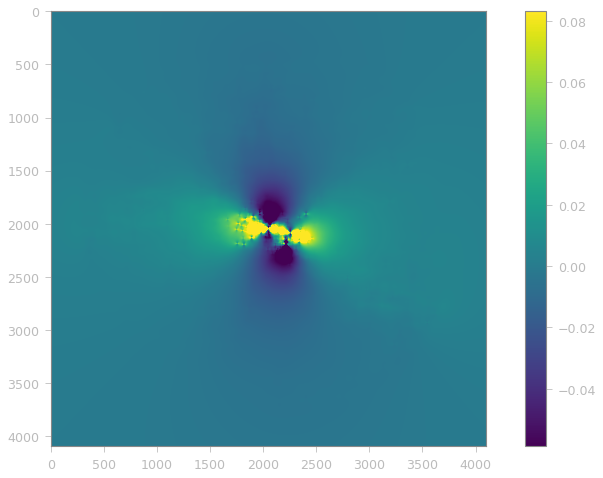

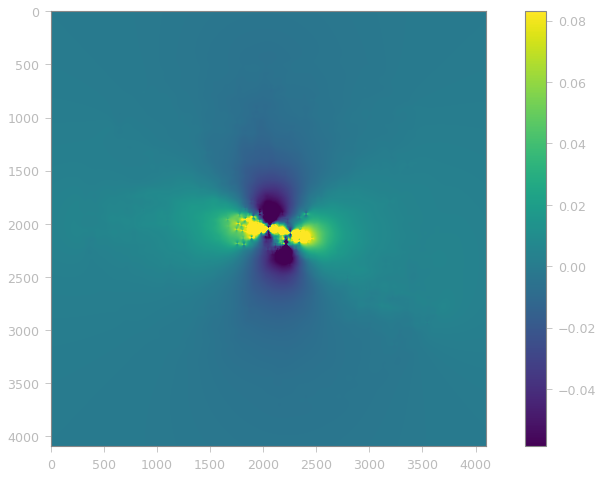

In [176]:
bt.plot.img(k)
bt.plot.img(gamma1)

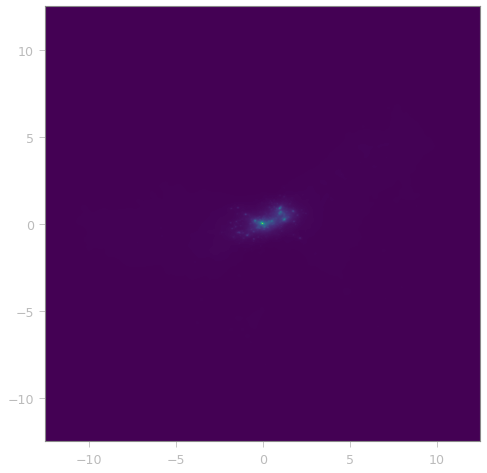

In [96]:
plt.figure(figsize=(8,8))
plt.imshow(k,extent=[alpha_data['xrays'].min()*xi0,alpha_data['xrays'].max()*xi0,alpha_data['yrays'].min()*xi0,alpha_data['yrays'].max()*xi0],origin='lower');

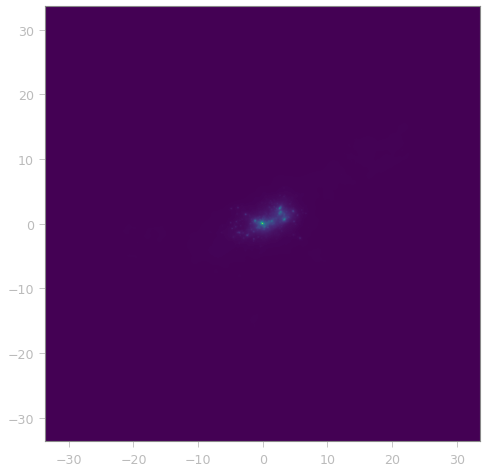

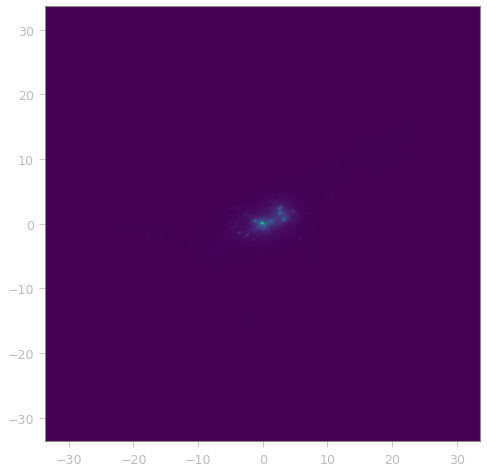

In [44]:
cplt.figure(figsize=(8,8))
plt.imshow(k,extent=[xs.min(),xs.max(),ys.min(),ys.max()],origin='lower');
plt.figure(figsize=(8,8))
plt.imshow(kappa,extent=[xs.min(),xs.max(),ys.min(),ys.max()],origin='lower');

In [83]:
def get_com(dist,xs,ys):
    x,y = np.meshgrid(ys,xs)
    cy = 1/np.sum(dist) * np.sum(dist*y)
    cx = 1/np.sum(dist) * np.sum(dist*x)
    return cx,cy

In [85]:
get_com(sigma_data['gas_sigma'],xs,ys)

(1.0335854163042928, -0.019295959915373646)

In [87]:
get_com(sigma_data['star_sigma'],xs,ys)

(0.8174187759417333, 0.4020921079442252)

958411982614.6531 138904180924.5265 4116746178311.99


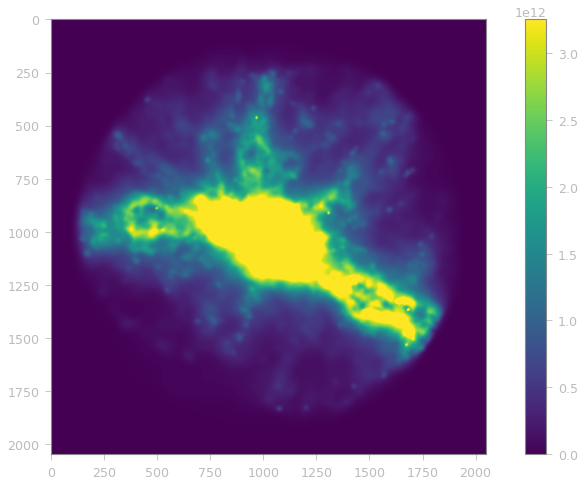

In [49]:
bt.plot.img(sigma_data['gas_sigma'],percentile=95)

In [175]:
alpha_data['xi0']

array(0.001)

<ipython-input-238-8b7011bb1af0>:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(kappa),extent=[xs.min(),xs.max(),ys.min(),ys.max()],vmin=np.log10(kappa_min),vmax=np.log10(kappa_max),origin='lower');


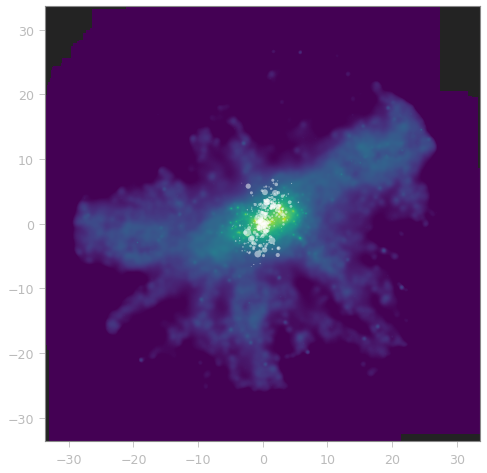

In [238]:
plt.figure(figsize=(8,8))
plt.imshow(np.log10(kappa),extent=[xs.min(),xs.max(),ys.min(),ys.max()],vmin=np.log10(kappa_min),vmax=np.log10(kappa_max),origin='lower');
plt.scatter(galaxy_x,galaxy_y,s=galaxy_data['mstar_30kpc']/5e9,color='w',alpha=0.5);

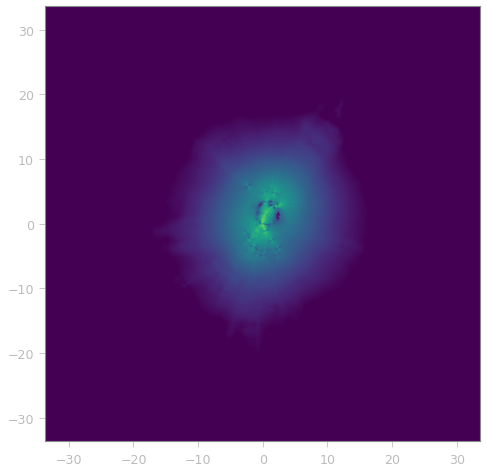

In [107]:
plt.figure(figsize=(8,8))
plt.imshow(np.log10(gamma).T,extent=[xs.min(),xs.max(),ys.min(),ys.max()],vmin=np.log10(gamma_min),vmax=np.log10(gamma_max),origin='lower')

In [9]:
def ks93(g1, g2, padFac):
    """Direct inversion of weak-lensing shear to convergence.
    This function is an implementation of the Kaiser & Squires (1993) mass
    mapping algorithm. Due to the mass sheet degeneracy, the convergence is
    recovered only up to an overall additive constant. It is chosen here to
    produce output maps of mean zero. The inversion is performed in Fourier
    space for speed.
    Parameters
    ----------
    g1, g2 : array_like
        2D input arrays corresponding to the first and second (i.e., real and
        imaginary) components of shear, binned spatially to a regular grid.
    Returns
    -------
    kE, kB : tuple of numpy arrays
        E-mode and B-mode maps of convergence.
    Raises
    ------
    AssertionError
        For input arrays of different sizes.
    See Also
    --------
    bin2d
        For binning a galaxy shear catalog.
    Examples
    --------
    >>> # (g1, g2) should in practice be measurements from a real galaxy survey
    >>> g1, g2 = 0.1 * np.random.randn(2, 32, 32) + 0.1 * np.ones((2, 32, 32))
    >>> kE, kB = ks93(g1, g2)
    >>> kE.shape
    (32, 32)
    >>> kE.mean()
    1.0842021724855044e-18
    """

    # Compute Fourier space grids
    (xlen, ylen) = g1.shape
    nx, ny = xlen*padFac, ylen*padFac
    # round to power of 2 to speed up FFT                                                        
    nx = np.int(2**(np.ceil(np.log2(nx))))
    ny = np.int(2**(np.ceil(np.log2(ny))))
    k2, k1 = np.meshgrid(np.fft.fftfreq(nx), np.fft.fftfreq(ny))

    # Compute Fourier transforms of g1 and g2
    g1hat = np.fft.fft2(g1,s=[nx,ny])
    g2hat = np.fft.fft2(g2,s=[nx,ny])

    # Apply Fourier space inversion operator
    p1 = k1 * k1 - k2 * k2
    p2 =  k1 * k2
    k2 = k1 * k1 + k2 * k2
    k2[0, 0] = 1  # avoid division by 0
    kEhat = (p1/2 * g1hat + p2/2 * g2hat) / k2
    kBhat = -(p2 /2* g1hat - p1/2 * g2hat) / k2

    # Transform back to pixel space
    kE = np.fft.ifft2(kEhat).real[:xlen,:ylen]
    kB = np.fft.ifft2(kBhat).real[:xlen,:ylen]
    
    return kE, kB

In [10]:
ke, kb = ks93(gamma1,gamma2,1.5)

NameError: name 'dl' is not defined

0.0020067702810927903 0.0011475059922690304 0.006561696726372295
0.0026487253168255543 0.0003236912485183396 0.017541942558099217


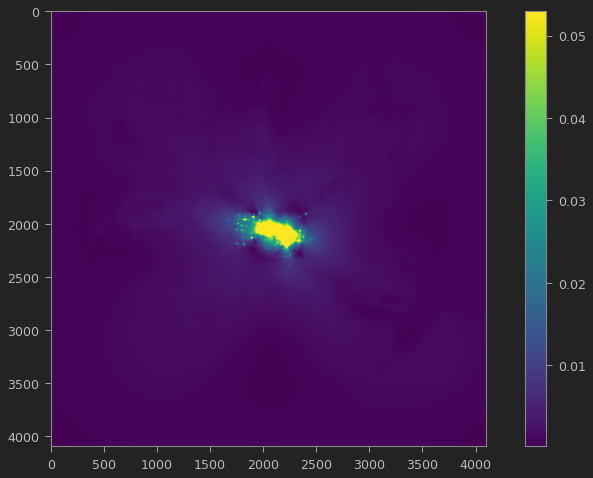

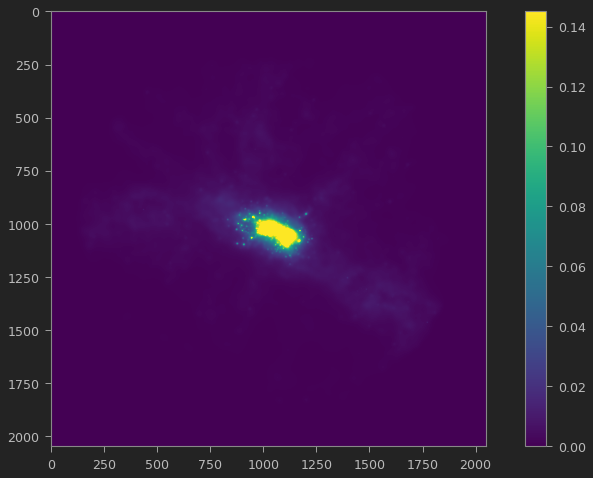

In [13]:
bt.plot.img(np.sqrt(ke**2+kb**2))
bt.plot.img(kappa)

In [11]:
def gamma_map_fourier(kappa,padFac):
    xlen, ylen = kappa.shape
    xpad, ypad = xlen*padFac, ylen*padFac
    # round to power of 2 to speed up FFT                                                        
    xpad = np.int(2**(np.ceil(np.log2(xpad))))
    ypad = np.int(2**(np.ceil(np.log2(ypad))))
    kappa_ft = np.fft.fft2(kappa,s=[xpad,ypad])
    # make a k-space grid                                                                        
    kxgrid, kygrid = np.meshgrid(np.fft.fftfreq(xpad),np.fft.fftfreq(ypad),indexing='ij')
    # unlike for deflection angles, don't care about the physical dimensions of the array 
    #(and s\o the physical k values), as the kappa and gamma k-factors are raised to the same powers         
    gamma1_kfac = (kxgrid**2 - kygrid**2) / (kxgrid**2 + kygrid**2)
    gamma2_kfac = 2*kxgrid*kygrid / (kxgrid**2 + kygrid**2)
    # [0,0] component mucked up by dividing by k^2                                               
    gamma1_kfac[0,0], gamma2_kfac[0,0] = 0,0
    gamma1_ft = gamma1_kfac * kappa_ft
    gamma2_ft = gamma2_kfac * kappa_ft
    gamma1 = np.fft.ifft2(gamma1_ft)[:xlen,:ylen]
    gamma2 = np.fft.ifft2(gamma2_ft)[:xlen,:ylen]
    return gamma1.real, gamma2.real

In [ ]:
def kappa_map_fourier(kappa,padFac):
    xlen, ylen = kappa.shape
    xpad, ypad = xlen*padFac, ylen*padFac
    # round to power of 2 to speed up FFT                                                        
    xpad = np.int(2**(np.ceil(np.log2(xpad))))
    ypad = np.int(2**(np.ceil(np.log2(ypad))))
    kappa_ft = np.fft.fft2(kappa,s=[xpad,ypad])
    # make a k-space grid                                                                        
    kxgrid, kygrid = np.meshgrid(np.fft.fftfreq(xpad),np.fft.fftfreq(ypad),indexing='ij')
    # unlike for deflection angles, don't care about the physical dimensions of the array 
    #(and s\o the physical k values), as the kappa and gamma k-factors are raised to the same powers         
    gamma1_kfac = (kxgrid**2 + kygrid**2) / (kxgrid**2 - kygrid**2)
    # [0,0] component mucked up by dividing by k^2                                               
    gamma1_kfac[0,0] = 0
    gamma1_ft =  kappa_ft*gamma1_kfac

    gamma1 = np.fft.ifft2(gamma1_ft)[:xlen,:ylen]
    return gamma1.real

In [7]:
def kappa_map_fourier(g1,g2,padFac):
    xlen, ylen = g1.shape
    xpad, ypad = xlen*padFac, ylen*padFac
    
    # round to power of 2 to speed up FFT                                                        
    xpad = np.int(2**(np.ceil(np.log2(xpad))))
    ypad = np.int(2**(np.ceil(np.log2(ypad))))
    
    g1hat = np.fft.fft2(g1,s=[xpad,ypad])
    g2hat = np.fft.fft2(g2,s=[xpad,ypad])
    
    # make a k-space grid                                                                        
    k1, k2 = np.meshgrid(np.fft.fftfreq(xpad),np.fft.fftfreq(ypad),indexing='ij')
    
    numer = (k1**2 - k2**2 - 2*1j*k1*k2)
    denom = k1**2+k2**2
    del k1,k2
    
    denom[0,0] = 1
    c = numer/denom
    del numer, denom
    
    khat = c*(g1hat + 1j*g2hat)
    del g1hat, g2hat

    k = np.fft.ifft2(khat)[:xlen,:ylen]
    return k.real

In [8]:
test = kappa_map_fourier(gamma1,gamma2,1.1)

In [14]:
np.max(test)

1.5203720317561085

No handles with labels found to put in legend.


Peak = 1156314 FWHM =  0.0013725845604972038


No handles with labels found to put in legend.


0.0001474563930451933 -0.00180075788398101 0.017496375063967718
Peak = 1824387 FWHM =  0.0001518215694701702
0.0026487253168255543 0.0003236912485183396 0.017541942558099217


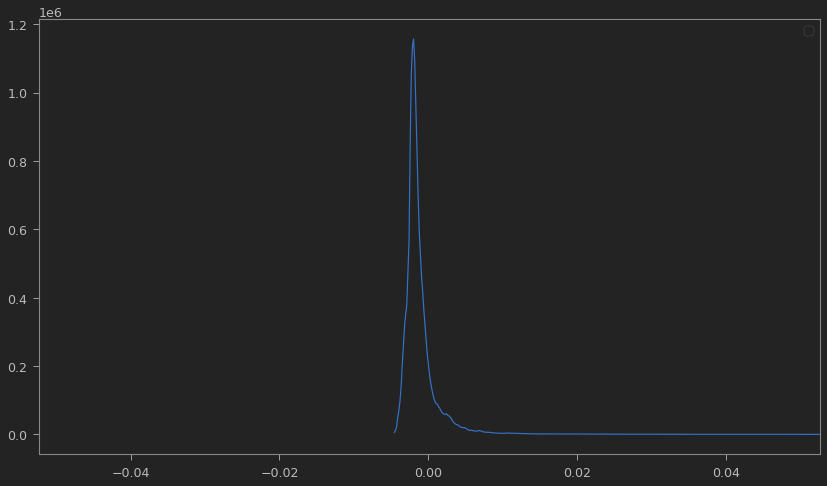

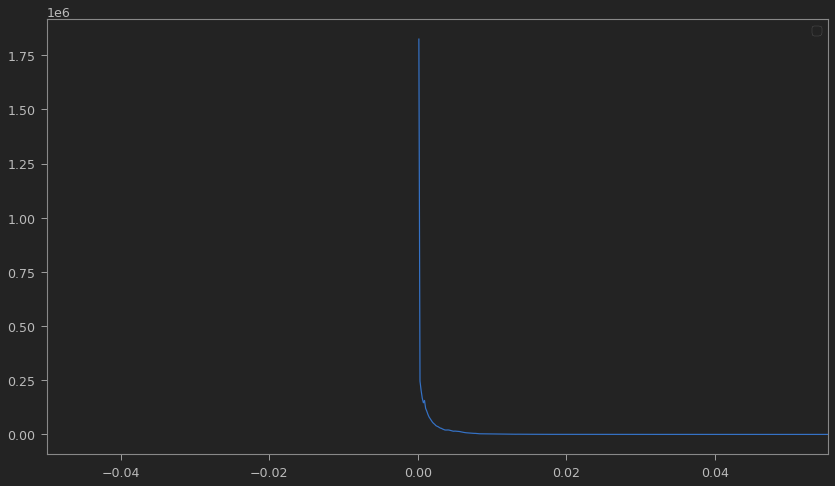

In [16]:
bt.plot.hist(test)
bt.plot.hist(kappa)

In [23]:
k = kappa_map_fourier(gamma1,2)

<ipython-input-22-30be3b4f2894>:12: RuntimeWarning: divide by zero encountered in true_divide
  gamma1_kfac = (kxgrid**2 + kygrid**2) / (kxgrid**2 - kygrid**2)
<ipython-input-22-30be3b4f2894>:12: RuntimeWarning: invalid value encountered in true_divide
  gamma1_kfac = (kxgrid**2 + kygrid**2) / (kxgrid**2 - kygrid**2)
<ipython-input-22-30be3b4f2894>:15: RuntimeWarning: invalid value encountered in multiply
  gamma1_ft =  kappa_ft*gamma1_kfac


In [12]:
g1 , g2 = gamma_map_fourier(kappa,2)

<ipython-input-11-1e5ddf16c382>:12: RuntimeWarning: invalid value encountered in true_divide
  gamma1_kfac = (kxgrid**2 - kygrid**2) / (kxgrid**2 + kygrid**2)
<ipython-input-11-1e5ddf16c382>:13: RuntimeWarning: invalid value encountered in true_divide
  gamma2_kfac = 2*kxgrid*kygrid / (kxgrid**2 + kygrid**2)


nan nan nan
-2.474224972976217e-05 -0.0003064697571657504 0.01227341121196469


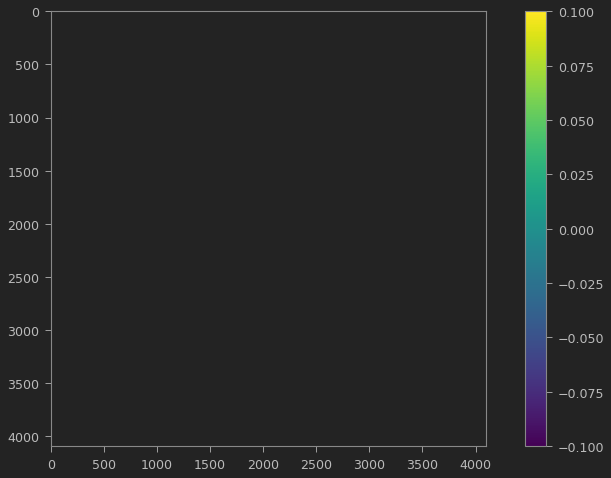

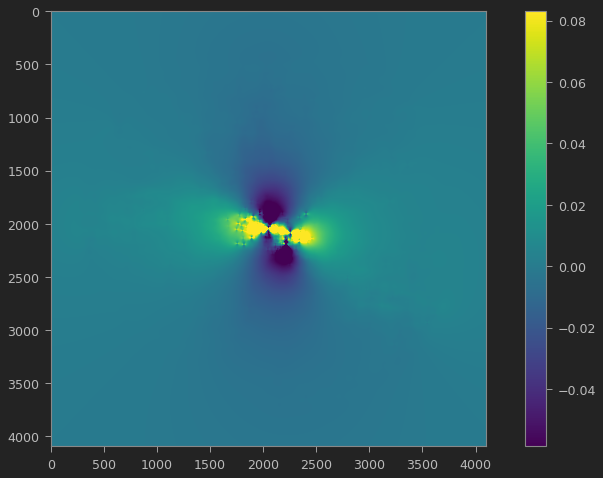

In [24]:
bt.plot.img(k)
bt.plot.img(gamma1)

In [67]:
np.meshgrid(xs,ys)

[array([[-33.62418807, -33.59133591, -33.55848375, ...,  33.55848375,
          33.59133591,  33.62418807],
        [-33.62418807, -33.59133591, -33.55848375, ...,  33.55848375,
          33.59133591,  33.62418807],
        [-33.62418807, -33.59133591, -33.55848375, ...,  33.55848375,
          33.59133591,  33.62418807],
        ...,
        [-33.62418807, -33.59133591, -33.55848375, ...,  33.55848375,
          33.59133591,  33.62418807],
        [-33.62418807, -33.59133591, -33.55848375, ...,  33.55848375,
          33.59133591,  33.62418807],
        [-33.62418807, -33.59133591, -33.55848375, ...,  33.55848375,
          33.59133591,  33.62418807]]),
 array([[-33.62418807, -33.62418807, -33.62418807, ..., -33.62418807,
         -33.62418807, -33.62418807],
        [-33.59133591, -33.59133591, -33.59133591, ..., -33.59133591,
         -33.59133591, -33.59133591],
        [-33.55848375, -33.55848375, -33.55848375, ..., -33.55848375,
         -33.55848375, -33.55848375],
        ...,


In [ ]:
plt.quiver(gamma1,gamma2)

In [118]:
g = gamma1 + 1j*gamma2
gf = np.fft.fft2(g)

In [129]:
g1f = gf.real
g2f = gf.imag
k1 = np.fft.fftfreq(gf.shape[0])
k2 = np.fft.fftfreq(gf.shape[1])

In [141]:
kk1 = np.zeros(gf.shape)
kk2 = np.zeros(gf.shape)
for i in range(len(k1)):
    kk1[i,:] = np.ones(kk1.shape[0])*k1[i]
    kk2[:,i] = np.ones(kk1.shape[1])*k2[i]

In [144]:
kf = 0.5* ((kk1**2 - kk2**2)/(kk1**2+kk2**2))*g1f + 0.5*((kk1*kk2)/(kk1**2+kk2**2))*g2f

<ipython-input-144-e4fc3f464145>:1: RuntimeWarning: invalid value encountered in true_divide
  kf = 0.5* ((kk1**2 - kk2**2)/(kk1**2+kk2**2))*g1f + 0.5*((kk1*kk2)/(kk1**2+kk2**2))*g2f


In [153]:
k =np.fft.ifft2(kf)

In [156]:
k.real

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [133]:
test = np.array([[1,1,1],[2,2,2]])

In [135]:
test

array([[1, 1, 1],
       [2, 2, 2]])

In [134]:
test[0,:]

array([1, 1, 1])

-7.056607300229278e-09 -1.75770850659911e-06 50.552456263648224


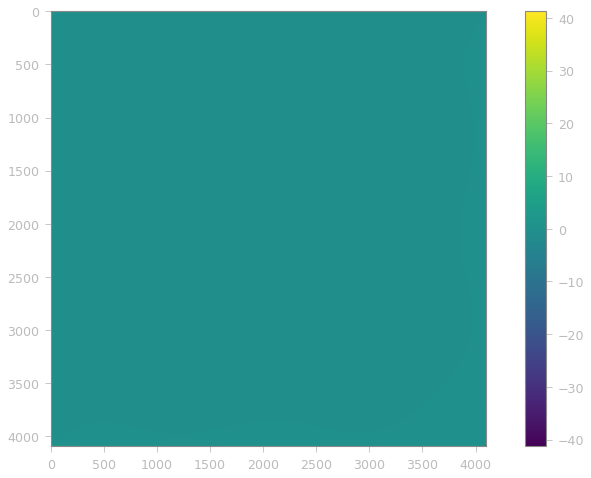

In [126]:
bt.plot.img(g1f)

In [115]:
del g1f, g2f